# Imports

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten
import time

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

# Data Loading

In [4]:
# !git clone https://github.com/grudloff/stock_market_GAN.git

In [5]:
stock_code = "TSLA"
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2021, 12, 31)
dataframe = pdr.get_data_yahoo(stock_code, start, end)
dataframe = dataframe.reset_index()

[*********************100%***********************]  1 of 1 completed


In [6]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,2.898000e+03
mean,40.978282,41.850743,40.056747,41.012763,41.012763,9.419163e+07
std,75.207373,76.854678,73.451602,75.288572,75.288572,8.470547e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,5.680000,6.015500,5.441667,5.821833,5.821833,3.853050e+07
50%,15.380667,15.651667,15.139333,15.372666,15.372666,7.455300e+07
75%,22.205667,22.651999,21.816000,22.255000,22.255000,1.199960e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [7]:
dataframe.shape

(2898, 7)

In [8]:
def add_Ma(dataframe):
  Ma_window=5
  for i in range(0,dataframe.shape[0]-Ma_window):
    dataframe.loc[dataframe.index[i+Ma_window],'Ma'] = np.round(((dataframe.iloc[i,4]+ dataframe.iloc[i+1,4] +dataframe.iloc[i+2,4] + dataframe.iloc[i+3,4]+ dataframe.iloc[i+4,4])/5),6)
  return dataframe[5:-5]

In [9]:
def plot_dataframe(dataframe):

  for column_name in dataframe.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(dataframe[column_name])

# Preprocessing

In [10]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    # shape : (n_batch, n_sequence, n_features)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    std[std==0] = 1
    samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
    targets = (targets - mean[:,3:4])/std[:,3:4] # The close value is our target
    return samples, targets

In [11]:
# Generarate 5 days sequences from all data
# TODO: How to deal with weekend lack of information?

n_sequence = 5
n_batch = 128
n_features = 7

def get_gen_train_test(dataframe):
  data = dataframe.drop(columns='Date').to_numpy()
  targets = data[:,3, None] #add none to have same number of dimensions as data
  #targets = data
  n_samples = data.shape[0]

  train_test_split=int(n_samples*0.9)

  data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
  data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)
  
  return data_gen_train, data_gen_test

# Baseline 

In [12]:
# baseline: use previous day as estimation for the next
squared_error = 0
def mean_squared_error(X, lenght = 5):
  squared_error = 0
  for i in range(0, X.shape[0] - lenght):
    x = X[i:i+lenght]
    mean = x.mean()
    std = x.std()
    x = (x - mean)/std
    y = (X[i+lenght] - mean)/std
    squared_error += np.square(x[-1]-y)
  return squared_error/X.shape[0]

In [13]:
def mean_squared_error(dataset):
  mse=0
  for X_batch, y_batch in dataset:
    # X_batch.shape : (n_batch, n_sequence, n_features)
    #mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
    mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
  mse /= len(dataset)
  return mse

# Utilities

In [14]:
def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true-y_pred))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)/y_true))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:] > y_true[:-1],tf.float32)
    return tf.reduce_mean((y_true[1:]-y_true[:-1])*mask)

# LSTM

In [15]:
def make_LSTM_model():
    inputs = Input(shape=(n_sequence, n_features,))
    lstm_1 = LSTM(units=10, return_sequences=False, activation='tanh', kernel_initializer='random_normal')(inputs)
    lstm_1_dropout = Dropout(0.9)(lstm_1)
    output_dense = Dense(n_features, activation=None)(lstm_1_dropout)
    output = LeakyReLU(alpha=0.5)(output_dense) 

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mse', metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model

# Visualization

In [16]:
metrics = ["loss", 'mse','mae','mape','rmse','ar']
def plot_history(history):
  for metric_name in metrics:  
    plt.figure()
    plt.title(metric_name)
    plt.plot(history.history[metric_name], label='train')
    plt.plot(history.history["val_"+metric_name], label='test')
    plt.legend()
  plt.show()

#plot_history(history)

In [17]:
def plot_frame(sequence, target, model):
  sequence, target = data_gen_test[0]
  y_pred = model.predict(sequence)
  y_true = target

  plt.figure()
  plt.title("closing price")
  plt.plot(y_true, label="true")
  plt.plot(y_pred, label="prediction")
  plt.legend()
  plt.show()

#plot_frame(*data_gen_test[0], lstm)

## Test

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm (LSTM)                 (None, 10)                720       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 7)                 77        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7)                 0         
                                                                 
Total params: 797
Trainable params: 797
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
21/21 [==============================] - 2s 27ms/st

21/21 [==============================] - 0s 5ms/step - loss: 4.6663 - mse: 4.6663 - mae: 1.5087 - mape: 1190.6119 - rmse: 2.1403 - ar: 0.9007 - val_loss: 4.7070 - val_mse: 4.1187 - val_mae: 1.4201 - val_mape: 1.8392 - val_rmse: 2.0053 - val_ar: 0.3245
Epoch 29/100
21/21 [==============================] - 0s 5ms/step - loss: 5.2953 - mse: 5.2953 - mae: 1.5404 - mape: 48.5601 - rmse: 2.2793 - ar: 0.9129 - val_loss: 4.6833 - val_mse: 4.0984 - val_mae: 1.4146 - val_mape: 1.8905 - val_rmse: 2.0004 - val_ar: 0.3227
Epoch 30/100
21/21 [==============================] - 0s 5ms/step - loss: 4.3788 - mse: 4.3788 - mae: 1.4713 - mape: 96.8123 - rmse: 2.0740 - ar: 0.8880 - val_loss: 4.6863 - val_mse: 4.0965 - val_mae: 1.4146 - val_mape: 1.8965 - val_rmse: 1.9995 - val_ar: 0.3287
Epoch 31/100
21/21 [==============================] - 0s 5ms/step - loss: 5.0175 - mse: 5.0175 - mae: 1.5373 - mape: 493.1537 - rmse: 2.2293 - ar: 0.8997 - val_loss: 4.6545 - val_mse: 4.0694 - val_mae: 1.4072 - val_mape: 1

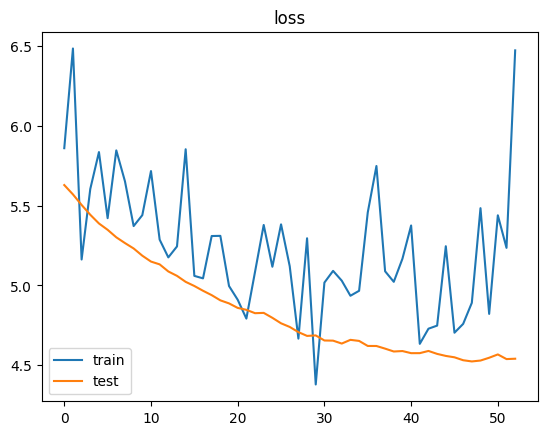

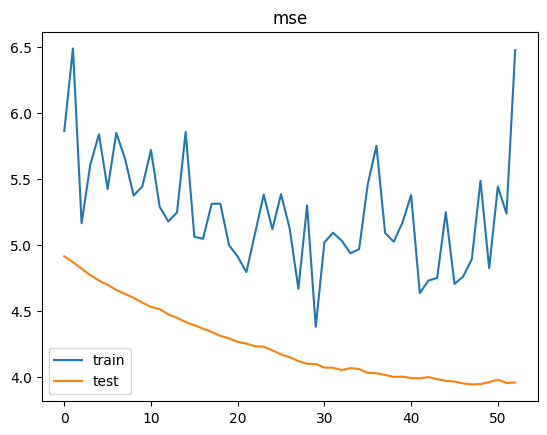

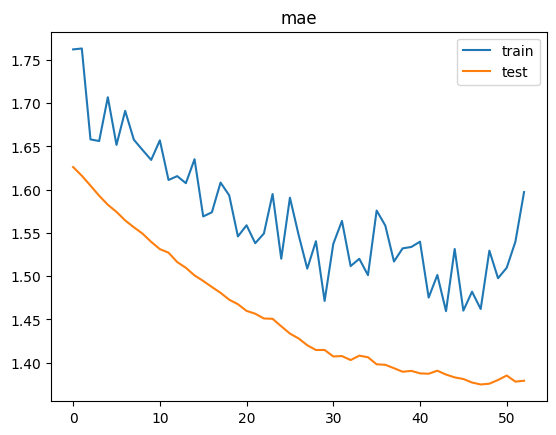

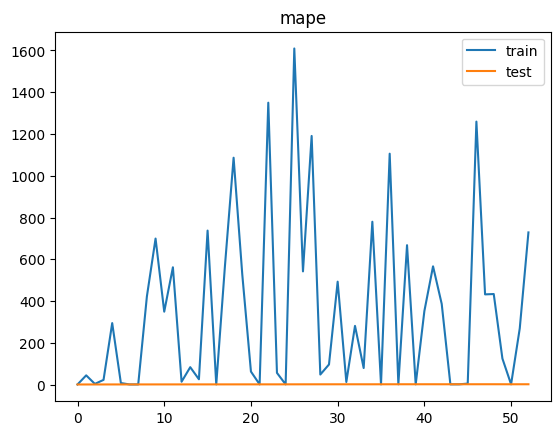

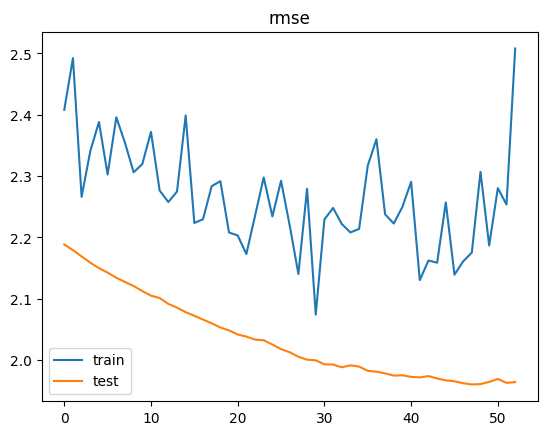

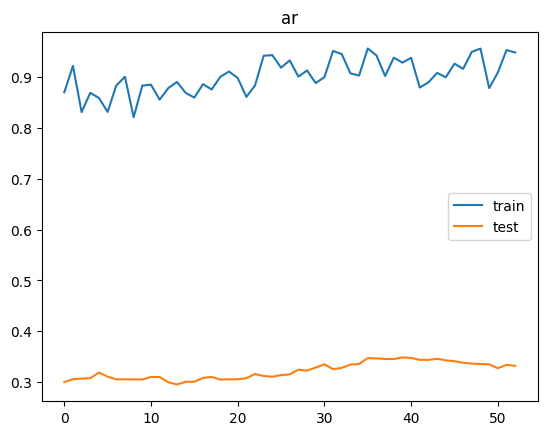

4/4 [==============================] - 0s 2ms/step


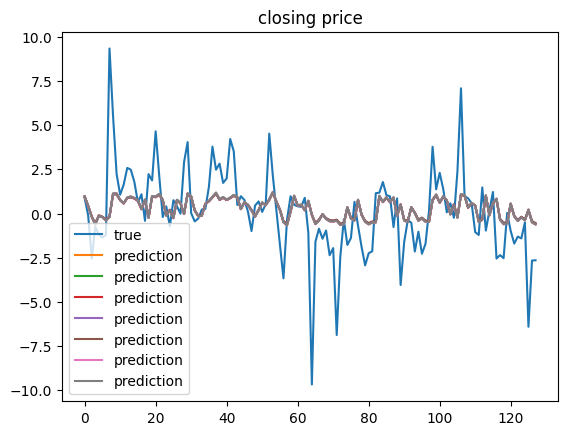

[MSE Baseline] train: 4.578299409943361  test: 3.5836892033120757


In [18]:
dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

lstm = make_LSTM_model()
history = lstm.fit(data_gen_train, validation_data=data_gen_test, epochs = 100,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], lstm)
lstm.save('lstm.h5')

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))